In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import pyCompare 
import matplotlib
import keras_tuner as kt

Using TensorFlow backend


In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from yellowbrick.regressor import PredictionError, ResidualsPlot
from matplotlib import pyplot as plt
%matplotlib inline
np.random.seed(42)
tf.random.set_seed(42)
from collections import Counter
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras_tuner.tuners import BayesianOptimization, Hyperband
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
sns.set(rc = {'figure.figsize': (10,6)})
sns.set(style="whitegrid",font_scale = 2 )

### Import, wrangle, and preprocess data

In [3]:
data = pd.read_csv('./Data/AGP_MMCNN_BSsurvey_pollock2014to2018.csv')
print(data.shape)
data.head(2)

(8629, 915)


,file_name,sample,final_age,latitude,length,gear_depth,gear_temp,wn11476.85064,wn11468.60577,wn11460.36091,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
0,WALLEYE_POLLOCK_157201603201_60411_OT1.0,training,10.0,53.97653,610.0,407.26,4.33,0.313066,0.313311,0.313633,...,1.316385,1.328887,1.339621,1.349055,1.357497,1.365173,1.372687,1.380318,1.387681,1.394300
1,WALLEYE_POLLOCK_157201603201_60412_OT1.0,training,9.0,53.97653,611.0,407.26,4.33,0.329684,0.330087,0.330593,...,1.314472,1.330901,1.345002,1.357586,1.369454,1.380857,1.391871,1.402634,1.413231,1.423495


In [4]:
# exclude outliers 
data.drop(data[data['sample'] == 'outlier'].index, inplace = True)
data.shape

(8617, 915)

In [5]:
data.rename(columns={"final_age":"Age"}, inplace=True) # rename column
data.isnull().values.any() # check if NaNs 

False

In [6]:
X_train = data[data['sample'] == 'training'] 
X_test = data[data['sample'] == 'test']
print(X_train.shape)
print(X_test.shape)

(6866, 915)
(1751, 915)


In [7]:
y_train=X_train.pop('Age')
y_test=X_test.pop('Age')
f_train=X_train.pop('file_name')
f_test=X_test.pop('file_name')
s_train=X_train.pop('sample')
s_test=X_test.pop('sample')

In [8]:
X_train_A=X_train[X_train.columns[0:4]]
X_train_A.head(2)

,latitude,length,gear_depth,gear_temp
0,53.97653,610.0,407.26,4.33
1,53.97653,611.0,407.26,4.33


In [9]:
X_test_A=X_test[X_test.columns[0:4]]
X_test_A.head(2)

,latitude,length,gear_depth,gear_temp
6866,53.82690,475.0,337.91,4.38
6867,53.60675,432.0,420.46,4.16


In [10]:
X_train_B=X_train[X_train.columns[4:]]
X_train_B.head(2)

,wn11476.85064,wn11468.60577,wn11460.36091,wn11452.11604,wn11443.87118,wn11435.62632,wn11427.38145,wn11419.13659,wn11410.89172,wn11402.64686,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
0,0.313066,0.313311,0.313633,0.314050,0.314400,0.314564,0.314640,0.314813,0.315161,0.315461,...,1.316385,1.328887,1.339621,1.349055,1.357497,1.365173,1.372687,1.380318,1.387681,1.394300
1,0.329684,0.330087,0.330593,0.330941,0.331056,0.331168,0.331501,0.332027,0.332488,0.332693,...,1.314472,1.330901,1.345002,1.357586,1.369454,1.380857,1.391871,1.402634,1.413231,1.423495


In [11]:
X_test_B=X_test[X_test.columns[4:]]
X_test_B.head(2)

,wn11476.85064,wn11468.60577,wn11460.36091,wn11452.11604,wn11443.87118,wn11435.62632,wn11427.38145,wn11419.13659,wn11410.89172,wn11402.64686,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
6866,0.349371,0.349258,0.349383,0.34944,0.349547,0.349898,0.350280,0.350478,0.350528,0.350582,...,1.169712,1.183594,1.195676,1.206412,1.216414,1.226195,1.235933,1.245539,1.254753,1.263192
6867,0.330212,0.330414,0.330697,0.33127,0.331903,0.332098,0.331886,0.331744,0.331770,0.331900,...,1.161812,1.176941,1.190388,1.202517,1.213842,1.224860,1.236009,1.247214,1.258091,1.268352


In [12]:
# preprocess spectra
preprTR = savgol_filter(X_train_B.values[:,:], 17, polyorder = 2,deriv=1) 
preprTE = savgol_filter(X_test_B.values[:,:], 17, polyorder = 2,deriv=1) 

In [13]:
X_train_B = pd.DataFrame(preprTR, index=X_train_B.index, columns=X_train_B.columns)
X_train_B.head(2)

,wn11476.85064,wn11468.60577,wn11460.36091,wn11452.11604,wn11443.87118,wn11435.62632,wn11427.38145,wn11419.13659,wn11410.89172,wn11402.64686,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
0,0.000357,0.000337,0.000317,0.000296,0.000276,0.000256,0.000236,0.000216,0.000195,0.000183,...,0.012600,0.011908,0.011003,0.010099,0.009194,0.008290,0.007385,0.006481,0.005576,0.004672
1,0.000323,0.000316,0.000308,0.000301,0.000293,0.000285,0.000278,0.000270,0.000263,0.000251,...,0.016221,0.015551,0.014613,0.013676,0.012738,0.011801,0.010863,0.009926,0.008988,0.008051


In [14]:
X_test_B = pd.DataFrame(preprTE, index=X_test_B.index, columns=X_test_B.columns)
X_test_B.head(2)

,wn11476.85064,wn11468.60577,wn11460.36091,wn11452.11604,wn11443.87118,wn11435.62632,wn11427.38145,wn11419.13659,wn11410.89172,wn11402.64686,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
6866,0.00013,0.000139,0.000147,0.000155,0.000164,0.000172,0.000180,0.000188,0.000197,0.000204,...,0.013741,0.013202,0.012445,0.011688,0.010931,0.010174,0.009417,0.008660,0.007903,0.007146
6867,0.00021,0.000215,0.000219,0.000224,0.000228,0.000233,0.000238,0.000242,0.000247,0.000245,...,0.014838,0.014391,0.013711,0.013030,0.012350,0.011670,0.010990,0.010309,0.009629,0.008949


Apply standard scaling (zero mean, unit deviation) to input variables

In [15]:
scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

In [16]:
scaler_x=StandardScaler()
scaler_x.fit(X_train_A)
X_train_A=pd.DataFrame(scaler_x.transform(X_train_A), columns=X_train_A.columns)
X_test_A=pd.DataFrame(scaler_x.transform(X_test_A), columns=X_test_A.columns)
X_train_A.head()

,latitude,length,gear_depth,gear_temp
0,-2.428245,1.312891,7.20376,0.596944
1,-2.428245,1.319904,7.20376,0.596944
2,-2.428245,0.141645,7.20376,0.596944
3,-2.428245,0.394129,7.20376,0.596944
4,-2.428245,0.197752,7.20376,0.596944


### Build and train MMCNN model

Build a model with support for hyperparameter tuning via keras tuner library

In [17]:
input_dim_A=X_train_A.shape[1]
input_dim_A

4

In [18]:
input_dim_B=X_train_B.shape[1]
input_dim_B

908

In [19]:
def build_model(hp): 
    input_A = Input(shape=(input_dim_A, ))
    x = input_A

    input_B = Input(shape=(input_dim_B,1))
    y = Conv1D(
        hp.Int('num_filters', 50, 100, step=10, default=50), 
        kernel_size=201, strides=101, activation='relu', padding='same')(input_B)
    y = Flatten()(y)
    y = Dense(4, activation="relu", name='output_B')(y)

    con = concatenate(inputs = [x,y] ) # merge

    z=Dense(
        hp.Int('dense', 4, 640, step=32, default=256), 
        activation='relu',
        )(con)
    z=Dropout(hp.Float('dropout-2', 0.0, 0.5, step=0.05, default=0.0))(z)
    
    output = Dense(1, activation="linear")(z)
    model = Model(inputs=[input_A, input_B], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    return model    

In [20]:
# instantiate the tuner
# the objective is to minimize valuation loss, which in this case is mean squared error
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    directory='Tuners',
    project_name='mmcnn',
    seed=42
)

Reloading Tuner from Tuners\mmcnn\tuner0.json


In [21]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_filters (Int)
{'default': 50, 'conditions': [], 'min_value': 50, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
dense (Int)
{'default': 256, 'conditions': [], 'min_value': 4, 'max_value': 640, 'step': 32, 'sampling': 'linear'}
dropout-2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}


In [22]:
# set up checkpoints, then start training and optimization
nb_epoch = 200
batch_size = 32
outputFilePath='Estimator'
checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=7,
                         verbose=1,
                         restore_best_weights=True
                         )

In [23]:
tuner.search([X_train_A, X_train_B], y_train,
            epochs=nb_epoch,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.25, 
            verbose=1,
            callbacks=[earlystop]
            )

In [24]:
model = tuner.get_best_models(num_models=1)[0]

In [25]:
best_hp = tuner.get_best_hyperparameters()[0]

In [26]:
best_hp.values

{'num_filters': 70,
 'dense': 516,
 'dropout-2': 0.30000000000000004,
 'tuner/epochs': 200,
 'tuner/initial_epoch': 67,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0204'}

In [27]:
# one more training pass
nb_epoch = 2000
batch_size = 32

outputFilePath = 'Estimator'

checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=100,
                         verbose=1,
                         restore_best_weights=True
                         )

In [28]:
history = model.fit([X_train_A, X_train_B], y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.25,
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Epoch 1/2000
151/161 [===========================>..] - ETA: 0s - loss: 0.0898 - mse: 0.0898 - mae: 0.2158
Epoch 1: val_loss improved from inf to 0.09704, saving model to Estimator
INFO:tensorflow:Assets written to: Estimator\assets


INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 5s 23ms/step - loss: 0.0913 - mse: 0.0913 - mae: 0.2171 - val_loss: 0.0970 - val_mse: 0.0970 - val_mae: 0.2338
Epoch 2/2000
154/161 [===========================>..] - ETA: 0s - loss: 0.0878 - mse: 0.0878 - mae: 0.2135
Epoch 2: val_loss did not improve from 0.09704
161/161 [==============================] - 1s 6ms/step - loss: 0.0899 - mse: 0.0899 - mae: 0.2149 - val_loss: 0.0998 - val_mse: 0.0998 - val_mae: 0.2337
Epoch 3/2000
153/161 [===========================>..] - ETA: 0s - loss: 0.0925 - mse: 0.0925 - mae: 0.2194
Epoch 3: val_loss did not improve from 0.09704
161/161 [==============================] - 1s 4ms/step - loss: 0.0918 - mse: 0.0918 - mae: 0.2190 - val_loss: 0.1065 - val_mse: 0.1065 - val_mae: 0.2349
Epoch 4/2000
153/161 [===========================>..] - ETA: 0s - loss: 0.0890 - mse: 0.0890 - mae: 0.2129
Epoch 4: val_loss did not improve from 0.09704
161/161 [==============================] - 1s 6ms/step - loss: 0.0899 - mse: 0

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 22ms/step - loss: 0.0886 - mse: 0.0886 - mae: 0.2123 - val_loss: 0.0943 - val_mse: 0.0943 - val_mae: 0.2280
Epoch 12/2000
156/161 [============================>.] - ETA: 0s - loss: 0.0903 - mse: 0.0903 - mae: 0.2160
Epoch 12: val_loss did not improve from 0.09432
161/161 [==============================] - 1s 5ms/step - loss: 0.0899 - mse: 0.0899 - mae: 0.2151 - val_loss: 0.1274 - val_mse: 0.1274 - val_mae: 0.2540
Epoch 13/2000
156/161 [============================>.] - ETA: 0s - loss: 0.0890 - mse: 0.0890 - mae: 0.2136
Epoch 13: val_loss did not improve from 0.09432
161/161 [==============================] - 1s 5ms/step - loss: 0.0892 - mse: 0.0892 - mae: 0.2143 - val_loss: 0.0945 - val_mse: 0.0945 - val_mae: 0.2272
Epoch 14/2000
159/161 [============================>.] - ETA: 0s - loss: 0.0910 - mse: 0.0910 - mae: 0.2138
Epoch 14: val_loss did not improve from 0.09432
161/161 [==============================] - 1s 5ms/step - loss: 0.0908 - 

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 20ms/step - loss: 0.0878 - mse: 0.0878 - mae: 0.2119 - val_loss: 0.0931 - val_mse: 0.0931 - val_mae: 0.2216
Epoch 16/2000
149/161 [==========================>...] - ETA: 0s - loss: 0.0887 - mse: 0.0887 - mae: 0.2145
Epoch 16: val_loss did not improve from 0.09305
161/161 [==============================] - 1s 5ms/step - loss: 0.0891 - mse: 0.0891 - mae: 0.2151 - val_loss: 0.1223 - val_mse: 0.1223 - val_mae: 0.2505
Epoch 17/2000
161/161 [==============================] - ETA: 0s - loss: 0.0903 - mse: 0.0903 - mae: 0.2164
Epoch 17: val_loss did not improve from 0.09305
161/161 [==============================] - 1s 5ms/step - loss: 0.0903 - mse: 0.0903 - mae: 0.2164 - val_loss: 0.1014 - val_mse: 0.1014 - val_mae: 0.2294
Epoch 18/2000
158/161 [============================>.] - ETA: 0s - loss: 0.0887 - mse: 0.0887 - mae: 0.2134
Epoch 18: val_loss did not improve from 0.09305
161/161 [==============================] - 1s 5ms/step - loss: 0.0885 - 

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 2s 15ms/step - loss: 0.0893 - mse: 0.0893 - mae: 0.2166 - val_loss: 0.0930 - val_mse: 0.0930 - val_mae: 0.2251
Epoch 23/2000
153/161 [===========================>..] - ETA: 0s - loss: 0.0864 - mse: 0.0864 - mae: 0.2117
Epoch 23: val_loss did not improve from 0.09297
161/161 [==============================] - 1s 5ms/step - loss: 0.0864 - mse: 0.0864 - mae: 0.2119 - val_loss: 0.1173 - val_mse: 0.1173 - val_mae: 0.2451
Epoch 24/2000
151/161 [===========================>..] - ETA: 0s - loss: 0.0899 - mse: 0.0899 - mae: 0.2151
Epoch 24: val_loss did not improve from 0.09297
161/161 [==============================] - 1s 5ms/step - loss: 0.0900 - mse: 0.0900 - mae: 0.2148 - val_loss: 0.0940 - val_mse: 0.0940 - val_mae: 0.2277
Epoch 25/2000
156/161 [============================>.] - ETA: 0s - loss: 0.0887 - mse: 0.0887 - mae: 0.2136
Epoch 25: val_loss did not improve from 0.09297
161/161 [==============================] - 1s 5ms/step - loss: 0.0890 - 

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 18ms/step - loss: 0.0861 - mse: 0.0861 - mae: 0.2110 - val_loss: 0.0921 - val_mse: 0.0921 - val_mae: 0.2215
Epoch 30/2000
160/161 [============================>.] - ETA: 0s - loss: 0.0873 - mse: 0.0873 - mae: 0.2124
Epoch 30: val_loss did not improve from 0.09213
161/161 [==============================] - 1s 5ms/step - loss: 0.0875 - mse: 0.0875 - mae: 0.2127 - val_loss: 0.0954 - val_mse: 0.0954 - val_mae: 0.2285
Epoch 31/2000
153/161 [===========================>..] - ETA: 0s - loss: 0.0847 - mse: 0.0847 - mae: 0.2117
Epoch 31: val_loss did not improve from 0.09213
161/161 [==============================] - 1s 5ms/step - loss: 0.0852 - mse: 0.0852 - mae: 0.2122 - val_loss: 0.0955 - val_mse: 0.0955 - val_mae: 0.2295
Epoch 32/2000
158/161 [============================>.] - ETA: 0s - loss: 0.0838 - mse: 0.0838 - mae: 0.2083
Epoch 32: val_loss improved from 0.09213 to 0.09202, saving model to Estimator
INFO:tensorflow:Assets written to: Estima

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 18ms/step - loss: 0.0835 - mse: 0.0835 - mae: 0.2079 - val_loss: 0.0920 - val_mse: 0.0920 - val_mae: 0.2256
Epoch 33/2000
157/161 [============================>.] - ETA: 0s - loss: 0.0855 - mse: 0.0855 - mae: 0.2094
Epoch 33: val_loss did not improve from 0.09202
161/161 [==============================] - 1s 4ms/step - loss: 0.0852 - mse: 0.0852 - mae: 0.2095 - val_loss: 0.0925 - val_mse: 0.0925 - val_mae: 0.2286
Epoch 34/2000
161/161 [==============================] - ETA: 0s - loss: 0.0866 - mse: 0.0866 - mae: 0.2113
Epoch 34: val_loss did not improve from 0.09202
161/161 [==============================] - 1s 4ms/step - loss: 0.0866 - mse: 0.0866 - mae: 0.2113 - val_loss: 0.1113 - val_mse: 0.1113 - val_mae: 0.2435
Epoch 35/2000
161/161 [==============================] - ETA: 0s - loss: 0.0895 - mse: 0.0895 - mae: 0.2163
Epoch 35: val_loss did not improve from 0.09202
161/161 [==============================] - 1s 5ms/step - loss: 0.0895 - 

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 18ms/step - loss: 0.0843 - mse: 0.0843 - mae: 0.2105 - val_loss: 0.0901 - val_mse: 0.0901 - val_mae: 0.2222
Epoch 38/2000
153/161 [===========================>..] - ETA: 0s - loss: 0.0849 - mse: 0.0849 - mae: 0.2107
Epoch 38: val_loss did not improve from 0.09005
161/161 [==============================] - 1s 5ms/step - loss: 0.0844 - mse: 0.0844 - mae: 0.2101 - val_loss: 0.0921 - val_mse: 0.0921 - val_mae: 0.2276
Epoch 39/2000
160/161 [============================>.] - ETA: 0s - loss: 0.0852 - mse: 0.0852 - mae: 0.2104
Epoch 39: val_loss did not improve from 0.09005
161/161 [==============================] - 1s 5ms/step - loss: 0.0851 - mse: 0.0851 - mae: 0.2103 - val_loss: 0.0919 - val_mse: 0.0919 - val_mae: 0.2236
Epoch 40/2000
155/161 [===========================>..] - ETA: 0s - loss: 0.0843 - mse: 0.0843 - mae: 0.2084
Epoch 40: val_loss improved from 0.09005 to 0.08833, saving model to Estimator
INFO:tensorflow:Assets written to: Estima

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 18ms/step - loss: 0.0833 - mse: 0.0833 - mae: 0.2075 - val_loss: 0.0883 - val_mse: 0.0883 - val_mae: 0.2199
Epoch 41/2000
159/161 [============================>.] - ETA: 0s - loss: 0.0855 - mse: 0.0855 - mae: 0.2092
Epoch 41: val_loss did not improve from 0.08833
161/161 [==============================] - 1s 4ms/step - loss: 0.0853 - mse: 0.0853 - mae: 0.2090 - val_loss: 0.1134 - val_mse: 0.1134 - val_mae: 0.2403
Epoch 42/2000
158/161 [============================>.] - ETA: 0s - loss: 0.0892 - mse: 0.0892 - mae: 0.2153
Epoch 42: val_loss did not improve from 0.08833
161/161 [==============================] - 1s 5ms/step - loss: 0.0897 - mse: 0.0897 - mae: 0.2156 - val_loss: 0.0989 - val_mse: 0.0989 - val_mae: 0.2286
Epoch 43/2000
155/161 [===========================>..] - ETA: 0s - loss: 0.0842 - mse: 0.0842 - mae: 0.2087
Epoch 43: val_loss did not improve from 0.08833
161/161 [==============================] - 1s 5ms/step - loss: 0.0844 - 

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 18ms/step - loss: 0.0800 - mse: 0.0800 - mae: 0.2038 - val_loss: 0.0852 - val_mse: 0.0852 - val_mae: 0.2112
Epoch 87/2000
148/161 [==========================>...] - ETA: 0s - loss: 0.0788 - mse: 0.0788 - mae: 0.2025
Epoch 87: val_loss did not improve from 0.08515
161/161 [==============================] - 1s 5ms/step - loss: 0.0797 - mse: 0.0797 - mae: 0.2030 - val_loss: 0.0909 - val_mse: 0.0909 - val_mae: 0.2230
Epoch 88/2000
152/161 [===========================>..] - ETA: 0s - loss: 0.0843 - mse: 0.0843 - mae: 0.2087
Epoch 88: val_loss did not improve from 0.08515
161/161 [==============================] - 1s 5ms/step - loss: 0.0844 - mse: 0.0844 - mae: 0.2087 - val_loss: 0.1511 - val_mse: 0.1511 - val_mae: 0.2778
Epoch 89/2000
156/161 [============================>.] - ETA: 0s - loss: 0.0868 - mse: 0.0868 - mae: 0.2126
Epoch 89: val_loss did not improve from 0.08515
161/161 [==============================] - 1s 5ms/step - loss: 0.0869 - 

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 17ms/step - loss: 0.0794 - mse: 0.0794 - mae: 0.2031 - val_loss: 0.0846 - val_mse: 0.0846 - val_mae: 0.2125
Epoch 103/2000
153/161 [===========================>..] - ETA: 0s - loss: 0.0810 - mse: 0.0810 - mae: 0.2042
Epoch 103: val_loss did not improve from 0.08458
161/161 [==============================] - 1s 4ms/step - loss: 0.0811 - mse: 0.0811 - mae: 0.2046 - val_loss: 0.0927 - val_mse: 0.0927 - val_mae: 0.2192
Epoch 104/2000
152/161 [===========================>..] - ETA: 0s - loss: 0.0823 - mse: 0.0823 - mae: 0.2084
Epoch 104: val_loss did not improve from 0.08458
161/161 [==============================] - 1s 4ms/step - loss: 0.0825 - mse: 0.0825 - mae: 0.2081 - val_loss: 0.0929 - val_mse: 0.0929 - val_mae: 0.2347
Epoch 105/2000
153/161 [===========================>..] - ETA: 0s - loss: 0.0799 - mse: 0.0799 - mae: 0.2028
Epoch 105: val_loss did not improve from 0.08458
161/161 [==============================] - 1s 5ms/step - loss: 0.0

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 16ms/step - loss: 0.0796 - mse: 0.0796 - mae: 0.2033 - val_loss: 0.0840 - val_mse: 0.0840 - val_mae: 0.2095
Epoch 118/2000
150/161 [==========================>...] - ETA: 0s - loss: 0.0824 - mse: 0.0824 - mae: 0.2077
Epoch 118: val_loss did not improve from 0.08404
161/161 [==============================] - 1s 5ms/step - loss: 0.0821 - mse: 0.0821 - mae: 0.2075 - val_loss: 0.0883 - val_mse: 0.0883 - val_mae: 0.2164
Epoch 119/2000
156/161 [============================>.] - ETA: 0s - loss: 0.0796 - mse: 0.0796 - mae: 0.2032
Epoch 119: val_loss did not improve from 0.08404
161/161 [==============================] - 1s 4ms/step - loss: 0.0789 - mse: 0.0789 - mae: 0.2024 - val_loss: 0.0857 - val_mse: 0.0857 - val_mae: 0.2130
Epoch 120/2000
155/161 [===========================>..] - ETA: 0s - loss: 0.0810 - mse: 0.0810 - mae: 0.2040
Epoch 120: val_loss did not improve from 0.08404
161/161 [==============================] - 1s 5ms/step - loss: 0.0

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 19ms/step - loss: 0.0788 - mse: 0.0788 - mae: 0.2026 - val_loss: 0.0839 - val_mse: 0.0839 - val_mae: 0.2142
Epoch 201/2000
156/161 [============================>.] - ETA: 0s - loss: 0.0782 - mse: 0.0782 - mae: 0.2035
Epoch 201: val_loss did not improve from 0.08393
161/161 [==============================] - 1s 4ms/step - loss: 0.0782 - mse: 0.0782 - mae: 0.2036 - val_loss: 0.0852 - val_mse: 0.0852 - val_mae: 0.2137
Epoch 202/2000
150/161 [==========================>...] - ETA: 0s - loss: 0.0768 - mse: 0.0768 - mae: 0.2019
Epoch 202: val_loss did not improve from 0.08393
161/161 [==============================] - 1s 5ms/step - loss: 0.0767 - mse: 0.0767 - mae: 0.2021 - val_loss: 0.1157 - val_mse: 0.1157 - val_mae: 0.2443
Epoch 203/2000
152/161 [===========================>..] - ETA: 0s - loss: 0.0764 - mse: 0.0764 - mae: 0.1991
Epoch 203: val_loss did not improve from 0.08393
161/161 [==============================] - 1s 5ms/step - loss: 0.0

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 18ms/step - loss: 0.0762 - mse: 0.0762 - mae: 0.1990 - val_loss: 0.0835 - val_mse: 0.0835 - val_mae: 0.2105
Epoch 252/2000
155/161 [===========================>..] - ETA: 0s - loss: 0.0779 - mse: 0.0779 - mae: 0.2031
Epoch 252: val_loss did not improve from 0.08354
161/161 [==============================] - 1s 4ms/step - loss: 0.0773 - mse: 0.0773 - mae: 0.2024 - val_loss: 0.0946 - val_mse: 0.0946 - val_mae: 0.2196
Epoch 253/2000
151/161 [===========================>..] - ETA: 0s - loss: 0.0758 - mse: 0.0758 - mae: 0.1996
Epoch 253: val_loss did not improve from 0.08354
161/161 [==============================] - 1s 5ms/step - loss: 0.0755 - mse: 0.0755 - mae: 0.1992 - val_loss: 0.0852 - val_mse: 0.0852 - val_mae: 0.2121
Epoch 254/2000
160/161 [============================>.] - ETA: 0s - loss: 0.0791 - mse: 0.0791 - mae: 0.2046
Epoch 254: val_loss did not improve from 0.08354
161/161 [==============================] - 1s 5ms/step - loss: 0.0

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 18ms/step - loss: 0.0756 - mse: 0.0756 - mae: 0.2016 - val_loss: 0.0835 - val_mse: 0.0835 - val_mae: 0.2120
Epoch 260/2000
150/161 [==========================>...] - ETA: 0s - loss: 0.0766 - mse: 0.0766 - mae: 0.2026
Epoch 260: val_loss did not improve from 0.08347
161/161 [==============================] - 1s 4ms/step - loss: 0.0770 - mse: 0.0770 - mae: 0.2031 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2139
Epoch 261/2000
156/161 [============================>.] - ETA: 0s - loss: 0.0788 - mse: 0.0788 - mae: 0.2044
Epoch 261: val_loss did not improve from 0.08347
161/161 [==============================] - 1s 5ms/step - loss: 0.0787 - mse: 0.0787 - mae: 0.2044 - val_loss: 0.0892 - val_mse: 0.0892 - val_mae: 0.2259
Epoch 262/2000
157/161 [============================>.] - ETA: 0s - loss: 0.0768 - mse: 0.0768 - mae: 0.2008
Epoch 262: val_loss did not improve from 0.08347
161/161 [==============================] - 1s 5ms/step - loss: 0.0

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 16ms/step - loss: 0.0738 - mse: 0.0738 - mae: 0.1957 - val_loss: 0.0831 - val_mse: 0.0831 - val_mae: 0.2092
Epoch 275/2000
161/161 [==============================] - ETA: 0s - loss: 0.0746 - mse: 0.0746 - mae: 0.1989
Epoch 275: val_loss did not improve from 0.08314
161/161 [==============================] - 1s 4ms/step - loss: 0.0746 - mse: 0.0746 - mae: 0.1989 - val_loss: 0.0867 - val_mse: 0.0867 - val_mae: 0.2210
Epoch 276/2000
152/161 [===========================>..] - ETA: 0s - loss: 0.0722 - mse: 0.0722 - mae: 0.1959
Epoch 276: val_loss did not improve from 0.08314
161/161 [==============================] - 1s 4ms/step - loss: 0.0718 - mse: 0.0718 - mae: 0.1956 - val_loss: 0.0972 - val_mse: 0.0972 - val_mae: 0.2221
Epoch 277/2000
154/161 [===========================>..] - ETA: 0s - loss: 0.0735 - mse: 0.0735 - mae: 0.1976
Epoch 277: val_loss did not improve from 0.08314
161/161 [==============================] - 1s 4ms/step - loss: 0.0

INFO:tensorflow:Assets written to: Estimator\assets


161/161 [==============================] - 3s 18ms/step - loss: 0.0751 - mse: 0.0751 - mae: 0.1988 - val_loss: 0.0827 - val_mse: 0.0827 - val_mae: 0.2078
Epoch 353/2000
155/161 [===========================>..] - ETA: 0s - loss: 0.0729 - mse: 0.0729 - mae: 0.1964
Epoch 353: val_loss did not improve from 0.08271
161/161 [==============================] - 1s 5ms/step - loss: 0.0730 - mse: 0.0730 - mae: 0.1967 - val_loss: 0.0865 - val_mse: 0.0865 - val_mae: 0.2158
Epoch 354/2000
157/161 [============================>.] - ETA: 0s - loss: 0.0762 - mse: 0.0762 - mae: 0.2014
Epoch 354: val_loss did not improve from 0.08271
161/161 [==============================] - 1s 4ms/step - loss: 0.0755 - mse: 0.0755 - mae: 0.2007 - val_loss: 0.0887 - val_mse: 0.0887 - val_mae: 0.2160
Epoch 355/2000
151/161 [===========================>..] - ETA: 0s - loss: 0.0726 - mse: 0.0726 - mae: 0.1958
Epoch 355: val_loss did not improve from 0.08271
161/161 [==============================] - 1s 5ms/step - loss: 0.0

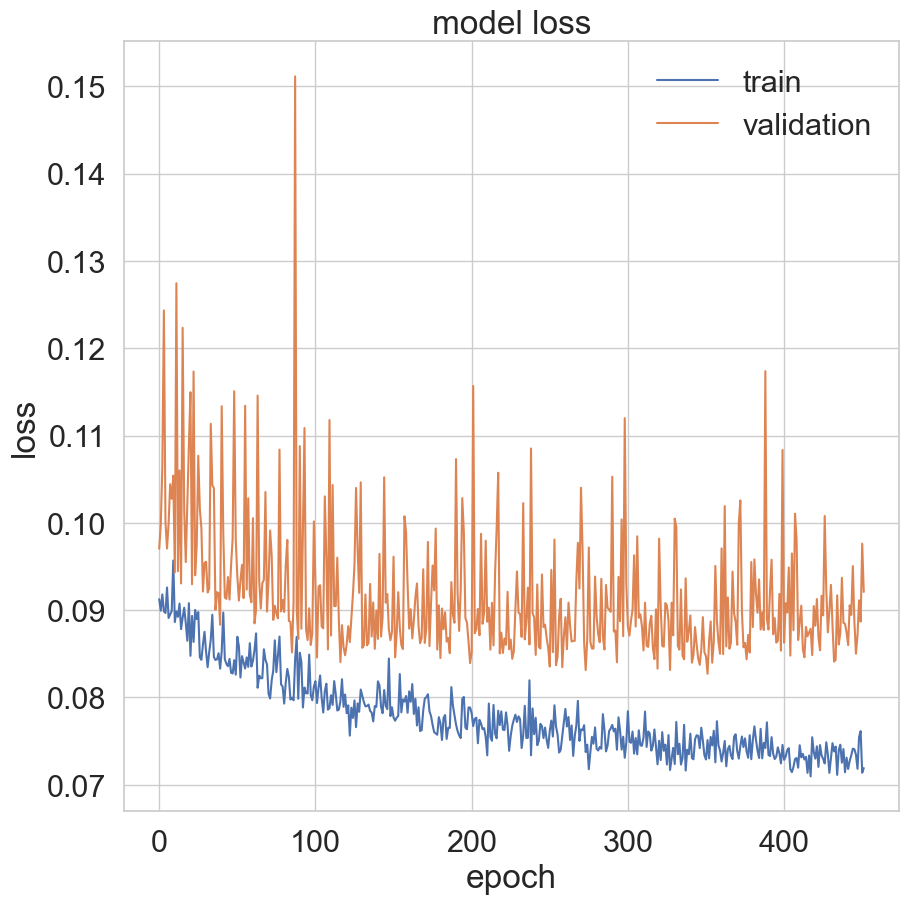

In [29]:
plt.figure(figsize=(10,10))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

Evaluate model and compute R2 score

In [30]:
model.evaluate([X_test_A,X_test_B], y_test)

55/55 [==============================] - 0s 2ms/step - loss: 0.0881 - mse: 0.0881 - mae: 0.2055


[0.08805804699659348, 0.08805804699659348, 0.2055099606513977]

In [31]:
preds=model.predict([X_test_A,X_test_B])

55/55 [==============================] - 0s 1ms/step


In [32]:
#from sklearn.metrics import r2_score
r2_score(y_test, preds)

0.9180484285279517

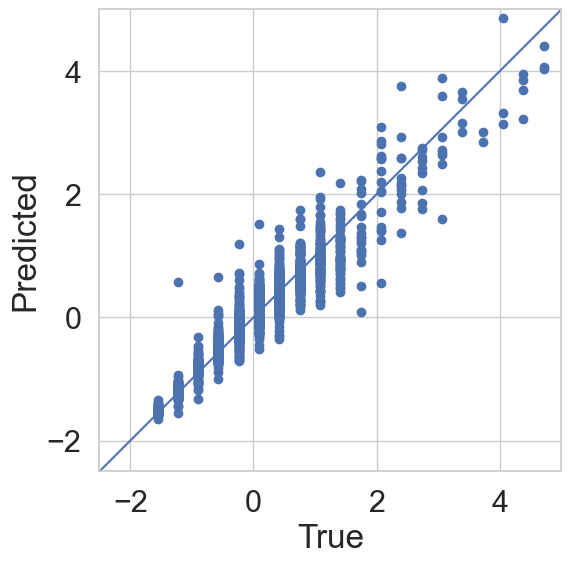

In [33]:
plt.figure(figsize=(6,6))
a = plt.axes(aspect='equal')
plt.scatter(y_test, preds)
plt.xlabel('True')
plt.ylabel('Predicted')
lims = [-2.5, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Error distribution

In [34]:
preds=preds.flatten()

In [35]:
y_test=y_test.flatten()

In [36]:
error = preds - y_test

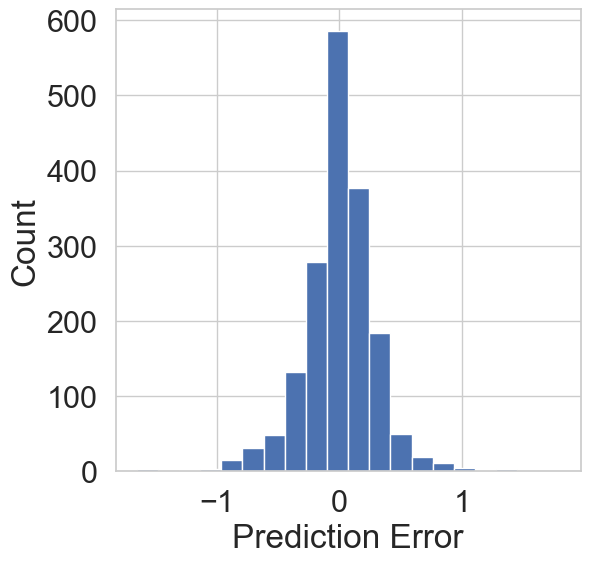

In [37]:
plt.figure(figsize=(6,6))
plt.hist(error, bins=20)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 908, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 9, 70)                14140     ['input_2[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 630)                  0         ['conv1d[0][0]']              
                                                                                                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                              

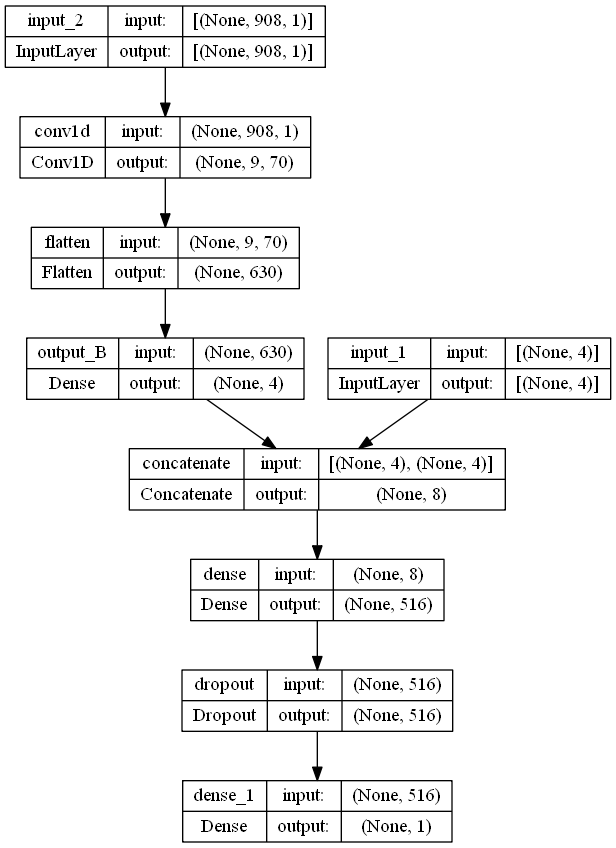

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Training data

In [40]:
# training set
preds_t=model.predict([X_train_A,X_train_B])
r2_score(y_train, preds_t)

215/215 [==============================] - 0s 1ms/step


0.9311289078855826

In [41]:
#undo normalization 
y_pr_transformed=scaler_y.inverse_transform(preds_t)
len(y_pr_transformed)

6866

In [42]:
y_tr_transformed=scaler_y.inverse_transform(y_train.reshape(-1, 1))
len(y_tr_transformed)

6866

In [43]:
r_squared_tr=r2_score(y_tr_transformed,y_pr_transformed)
round(r_squared_tr,2)

0.93

In [44]:
rmse_tr = sqrt(mean_squared_error(y_tr_transformed, y_pr_transformed))
round(rmse_tr,2)

0.8

In [45]:
#need to join y_tr_transformed, y_pr_transformed, f_train 
y_tr_df = pd.DataFrame(y_tr_transformed)
y_tr_df.columns =['train']
y_tr_df['pred']=y_pr_transformed
f_train_reset=f_train.reset_index()
del f_train_reset['index']
y_tr_df['file']=f_train_reset
y_tr_df.head(2)

,train,pred,file
0,10.0,10.655678,WALLEYE_POLLOCK_157201603201_60411_OT1.0
1,9.0,8.923623,WALLEYE_POLLOCK_157201603201_60412_OT1.0


In [46]:
y_tr_df.to_csv('./Output/Data/train_predictions.csv')

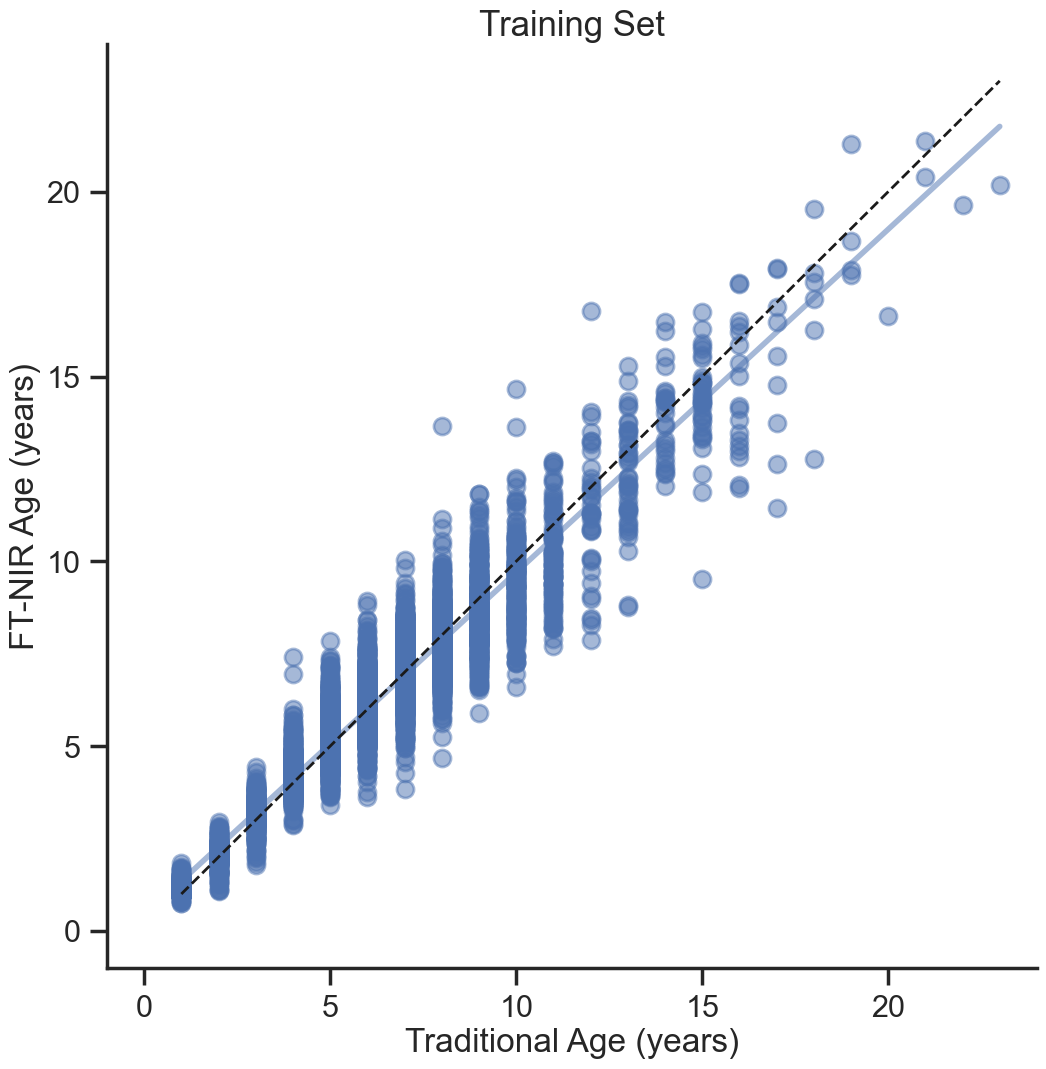

In [47]:
sns.set_style("white")
sns.set(style="ticks")
sns.set_context("poster")

f, ax = plt.subplots(figsize=(12, 12))
p=sns.regplot(x=y_tr_transformed, y=y_pr_transformed, ci=None, scatter_kws={"edgecolor": 'b','linewidth':2,"alpha": 0.5, "s": 150}, line_kws = {"alpha": 0.5, "lw":4})
ax.plot([y_tr_transformed.min(), y_tr_transformed.max()], [y_tr_transformed.min(), y_tr_transformed.max()], 'k--', lw=2)

# control x and y limits
p.set(xlim=(-1, 24))
p.set(ylim=(-1, 24))
sns.despine()
plt.title('Training Set', fontsize = 25)
plt.xlabel('Traditional Age (years)')
plt.ylabel('FT-NIR Age (years)')
plt.savefig('./Output/Figures/TrainingSet.png')

#### Test data

In [48]:
#undo normalization 
y_pred_transformed=scaler_y.inverse_transform(preds.reshape(-1, 1))
y_test_transformed=scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [49]:
r_squared=r2_score(y_test_transformed,y_pred_transformed)
round(r_squared,2)

0.92

In [50]:
rmse = sqrt(mean_squared_error(y_test_transformed, y_pred_transformed))
round(rmse,2)

0.9

In [51]:
#need to join y_test_transformed, y_pred_transformed, f_test=X_test.pop('file_name') 
y_test_df = pd.DataFrame(y_test_transformed)
y_test_df.columns =['test']
y_test_df['pred']=y_pred_transformed
f_test_reset=f_test.reset_index()
del f_test_reset['index']
y_test_df['file']=f_test_reset
y_test_df.head(2)

,test,pred,file
0,8.0,7.129107,WALLEYE_POLLOCK_157201603201_60482_OT1.0
1,7.0,5.272977,WALLEYE_POLLOCK_157201603201_60560_OT1.0


In [52]:
y_test_df.to_csv('./Output/Data/test_predictions.csv')

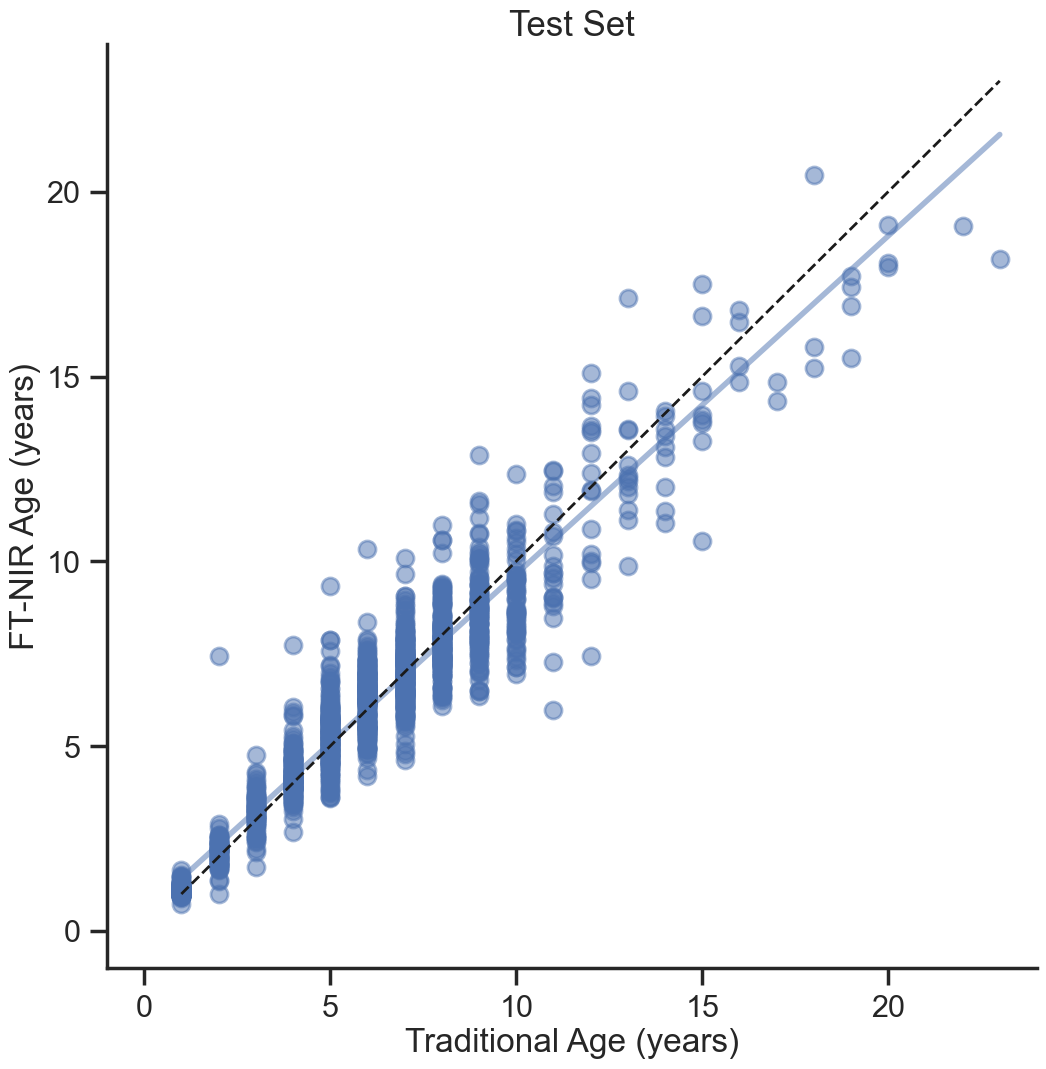

In [53]:
f, ax = plt.subplots(figsize=(12, 12))
p=sns.regplot(x=y_test_transformed, y=y_pred_transformed, ci=None, scatter_kws={"edgecolor": 'b','linewidth':2,"alpha": 0.5, "s": 150}, line_kws = {"alpha": 0.5, "lw":4})
ax.plot([y_test_transformed.min(), y_test_transformed.max()], [y_test_transformed.min(), y_test_transformed.max()], 'k--', lw=2)

# control x and y limits
p.set(xlim=(-1, 24))
p.set(ylim=(-1, 24))
sns.despine()
plt.title('Test Set', fontsize = 25)
plt.xlabel('Traditional Age (years)')
plt.ylabel('FT-NIR Age (years)')
plt.savefig('./Output/Figures/TestSet.png')

In [54]:
pyCompare.blandAltman(y_test_transformed.flatten(), y_pred_transformed.flatten(), #used flatten() to change to 1d array
                      limitOfAgreement=1.96, confidenceInterval=95,
                      confidenceIntervalMethod='approximate',
                      detrend=None, percentage=False,
                      title='Bland-Altman Plot\n',
                      savePath='./Output/Figures/BlandAltman.png'
                      )